# Pertemuan 21 - Data Science
---
## Project Data Science Machine Learning
---
## Telco Customer Churn

- **Problem Statement** : Buatlah Machine Learning untuk memprediksi apakah pelanggan akan berhenti berlangganan layanan telekomunikasi.

- **Output** : Membangun model machine learning yang dapat mengklasifikasikan pelanggan menjadi Churn atau Not Churn.

- **Manfaat** : Membantu perusahaan telekomunikasi melakukan langkah pencegahan untuk mempertahankan pelanggan.

- **Machine Learning Task** : Classification.

- **Algoritma Utama** : Logistic Regression (bisa dibandingkan dengan Random Forest/XGBoost nanti).

### Dataset

- **Sumber** : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

- **Jumlah data** : ± 7.043 baris

- **Fitur utama** : gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, InternetService, Contract, MonthlyCharges, dll.

- **Target** : Churn (Yes/No)

### Machine Learning

Karena target (Churn) adalah kategori Yes atau No, maka ini termasuk Supervised Learning dengan jenis Classification.

**Algoritma yang cocok** :

- Logistic Regression

- Random Forest

- XGBoost

- Gradient Boosting

- Support Vector Machine

mulai dari Logistic Regression untuk baseline, lalu bandingkan dengan model yang lebih kompleks.

### Langkah Pengerjaan

- Data Loading (import dataset dari Kaggle atau lokal)

- Data Understanding (cek tipe data, missing value, distribusi target)

- Data Cleaning (handle missing value, ubah tipe data)

- EDA (Exploratory Data Analysis) (visualisasi distribusi churn, hubungan fitur dengan churn)

- Feature Engineering (encoding kategori, scaling numerik)

- Modeling (training & testing beberapa algoritma)

- Evaluation (accuracy, precision, recall, F1-score)

---

## 1. Import & konfigurasi awal

In [1]:
# 1_imports_and_config.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
sns.set(style="whitegrid")


## 2. Load dataset & lihat sekilas

In [2]:
# 2_load_data.py
DATA_PATH = "customer-churn.csv"  # ganti kalau perlu
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Data understanding — info, missing, distribusi target

In [342]:
# 3_data_understanding.py
print("Info:")
print(df.info())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   ob

In [3]:
print("\nMissing per column:")
print(df.isna().sum())


Missing per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [4]:
print("\nUnique values (sample cols):")
print(df['Churn'].value_counts(), "\n")
print("Churn %: \n", df['Churn'].value_counts(normalize=True)*100)


Unique values (sample cols):
Churn
No     5174
Yes    1869
Name: count, dtype: int64 

Churn %: 
 Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


## 4. Data cleaning (TotalCharges, SeniorCitizen, drop id)

In [5]:
# 4_data_cleaning.py
# convert TotalCharges -> numeric (coerce errors to NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("TotalCharges null before:", df['TotalCharges'].isna().sum())

TotalCharges null before: 11


In [6]:
# Drop rows with missing TotalCharges (biasanya kecil sekitar 11)
df = df[~df['TotalCharges'].isna()].copy()
df.reset_index(drop=True, inplace=True)
print("Shape after dropping TotalCharges-null:", df.shape)

Shape after dropping TotalCharges-null: (7032, 21)


In [7]:
# Convert SeniorCitizen 0/1 -> 'Yes'/'No' (optional, keep as categorical)
df['SeniorCitizen'] = df['SeniorCitizen'].map({1:'Yes', 0:'No'})

In [8]:
# Drop customerID (identifier)
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

In [9]:
# Final quick check
print(df.dtypes)
print(df.isna().sum().sum(), "total missing values")

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object
0 total missing values


## 5. EDA singkat (visual) — distribusi target & fitur penting

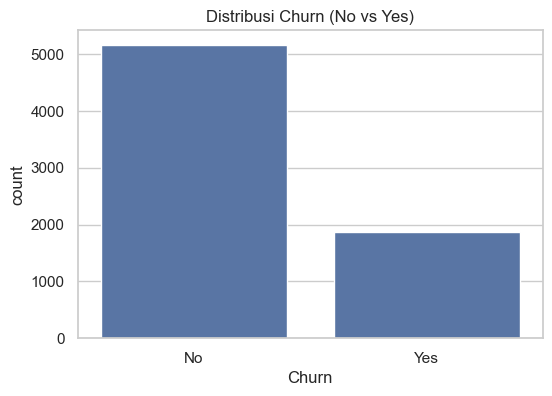

In [10]:
# 5_eda.py
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Distribusi Churn (No vs Yes)')
plt.show()

In [11]:
# Contract vs Churn (persen)
ct = pd.crosstab(df['Contract'], df['Churn'], normalize='index')*100
print(ct.round(2))

Churn              No    Yes
Contract                    
Month-to-month  57.29  42.71
One year        88.72  11.28
Two year        97.15   2.85


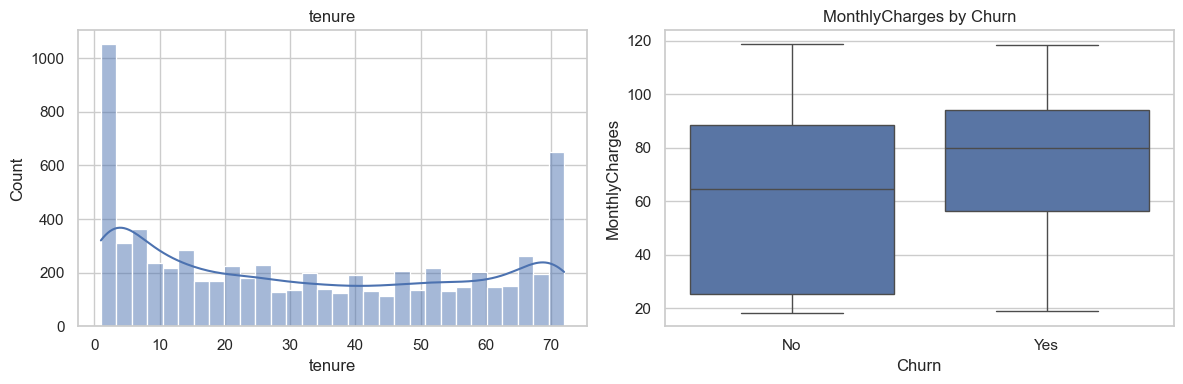

In [14]:
# Numeric distributions
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); sns.histplot(df['tenure'], bins=30, kde=True); plt.title('tenure')
plt.subplot(1,2,2); sns.boxplot(x='Churn', y='MonthlyCharges', data=df); plt.title('MonthlyCharges by Churn')
plt.tight_layout()
plt.show()

## 6. Siapkan preprocessing (feature engineering sederhana)
Kita pisahkan kolom numerik dan kategorikal, dan bangun ColumnTransformer. Pastikan OneHotEncoder(handle_unknown='ignore') agar inference lebih aman.

In [15]:
# 6_preprocessing.py
# target
y = df['Churn'].map({'Yes':1, 'No':0})
X = df.drop(columns=['Churn'])

In [16]:
# numeric & categorical lists (sesuaikan jika perlu)
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [c for c in X.columns if c not in num_cols]

In [17]:
print("Numeric cols:", num_cols)
print("Categorical cols sample:", cat_cols[:8])

Numeric cols: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical cols sample: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity']


In [18]:
# transformers
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

## 7. Train-test split (stratify agar proporsi churn tetap)

In [19]:
# 7_train_test_split.py
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn %:", y_train.mean(), "Test churn %:", y_test.mean())


Train shape: (5625, 19) Test shape: (1407, 19)
Train churn %: 0.2657777777777778 Test churn %: 0.2658137882018479


## 8. Baseline — Logistic Regression pipeline + cross-val AUC

In [20]:
# 8_baseline_logreg.py
pipe_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))
])

In [21]:
# Cross-val ROC AUC (baseline)
cv_scores = cross_val_score(pipe_logreg, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print("LogReg CV ROC AUC:", cv_scores.mean().round(4), cv_scores)

LogReg CV ROC AUC: 0.8456 [0.83678646 0.8737033  0.84024634 0.81829666 0.8592038 ]


In [22]:
# Fit final model
pipe_logreg.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 9. Evaluate Logistic on test set (metrics + confusion matrix + ROC)

In [23]:
# 9_eval_logreg.py
y_proba = pipe_logreg.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7256574271499645
Precision: 0.4901315789473684
Recall: 0.7967914438502673
F1: 0.6069246435845214

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



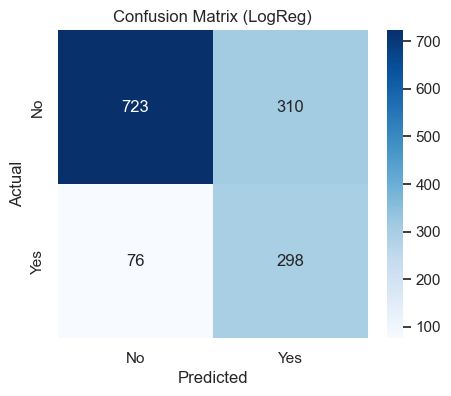

In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (LogReg)')
plt.show()

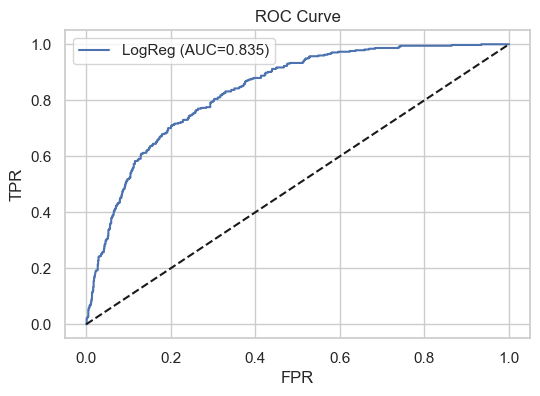

In [25]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'LogReg (AUC={roc_auc_score(y_test,y_proba):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title('ROC Curve')
plt.show()

In [26]:
data_baru = pd.DataFrame({
    'gender': ['Female'],
    'SeniorCitizen': ['No'],  # Use 'No' or 'Yes' as in the cleaned data
    'Partner': ['Yes'],
    'Dependents': ['No'],
    'tenure': [12],
    'PhoneService': ['Yes'],
    'MultipleLines': ['No'],
    'InternetService': ['Fiber optic'],
    'OnlineSecurity': ['No'],
    'OnlineBackup': ['Yes'],
    'DeviceProtection': ['No'],
    'TechSupport': ['Yes'],
    'StreamingTV': ['Yes'],
    'StreamingMovies': ['Yes'],
    'Contract': ['Month-to-month'],
    'PaperlessBilling': ['Yes'],
    'PaymentMethod': ['Electronic check'],
    'MonthlyCharges': [70.35],
    'TotalCharges': [845.5]
})

prediksi = pipe_logreg.predict(data_baru)
print("Prediksi:", prediksi[0])

proba = pipe_logreg.predict_proba(data_baru)
print("Probabilitas Tidak Churn:", proba[0][0])
print("Probabilitas Churn:", proba[0][1])


Prediksi: 1
Probabilitas Tidak Churn: 0.13357519174059584
Probabilitas Churn: 0.8664248082594042


## 10. Perbandingan: Random Forest & (opsional) XGBoost

In [27]:
# 10_compare_models.py
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))])

# Try XGBoost if tersedia
try:
    import xgboost as xgb
    pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=RANDOM_STATE))])
    have_xgb = True
except Exception:
    print("XGBoost tidak tersedia, akan dilewati.")
    have_xgb = False

models = {'LogReg': pipe_logreg, 'RandomForest': pipe_rf}
if have_xgb:
    models['XGBoost'] = pipe_xgb

# Quick CV compare (ROC AUC)
for name, m in models.items():
    scores = cross_val_score(m, X_train, y_train, cv=4, scoring='roc_auc', n_jobs=-1)
    print(f"{name} CV ROC AUC: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Fit RF and XGB to train (if chosen to evaluate)
pipe_rf.fit(X_train, y_train)
if have_xgb:
    pipe_xgb.fit(X_train, y_train)


LogReg CV ROC AUC: 0.8470 (+/- 0.0086)
RandomForest CV ROC AUC: 0.8239 (+/- 0.0063)
XGBoost CV ROC AUC: 0.8239 (+/- 0.0099)


## 11. Evaluate best model (ambil yang performa terbaik)
Contoh evaluasi XGBoost jika ada, else RandomForest or LogReg:

In [28]:
# 11_eval_best.py
best_model = None
if have_xgb:
    best_model = pipe_xgb
else:
    best_model = pipe_logreg  # atau pipe_logreg jika prefer sederhana

y_proba_b = best_model.predict_proba(X_test)[:,1]
y_pred_b = (y_proba_b >= 0.5).astype(int)

print("Best model metrics:")
print("AUC:", roc_auc_score(y_test, y_proba_b))
print(classification_report(y_test, y_pred_b))


Best model metrics:
AUC: 0.8088403538833469
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1033
           1       0.57      0.53      0.55       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.70      1407
weighted avg       0.76      0.77      0.76      1407



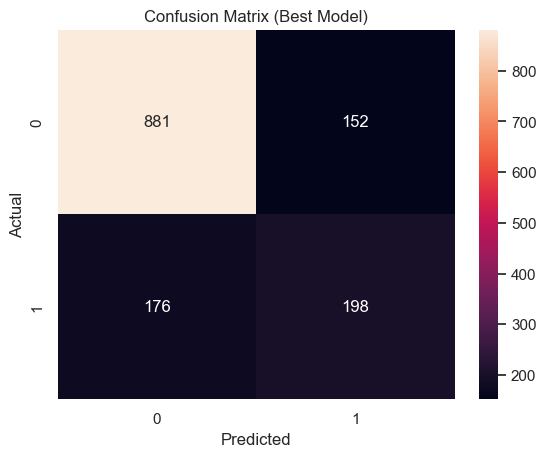

In [29]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_b)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

## 12. Interpretability: feature names & importance / koefisien

Contract_Month-to-month           0.389130
InternetService_Fiber optic       0.261717
OnlineSecurity_No                 0.026820
InternetService_DSL               0.024040
Contract_Two year                 0.023885
TechSupport_No                    0.021364
InternetService_No                0.019361
PhoneService_No                   0.013510
Contract_One year                 0.013213
tenure                            0.013034
MultipleLines_No                  0.012803
StreamingMovies_Yes               0.012682
PaymentMethod_Electronic check    0.010484
OnlineBackup_No                   0.009787
MultipleLines_Yes                 0.009077
dtype: float32

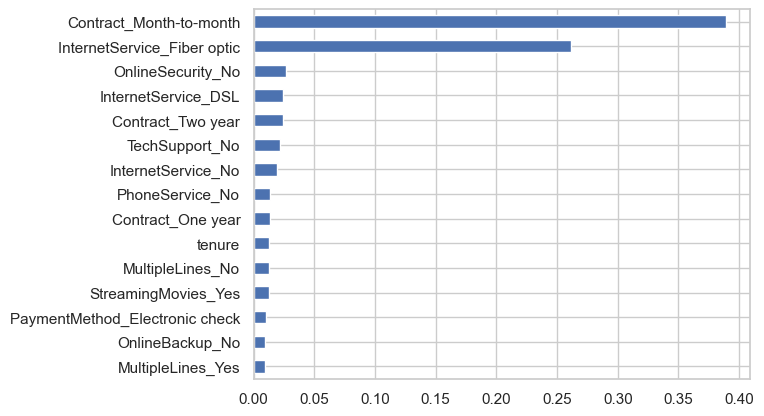

In [30]:
# 12_interpretability.py
# Dapatkan nama fitur setelah preprocessing
pre = best_model.named_steps['preprocessor']
num_names = num_cols
ohe = pre.named_transformers_['cat'].named_steps['ohe']
cat_ohe_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_names, cat_ohe_names])

# Jika model tree-based
if hasattr(best_model.named_steps['clf'], "feature_importances_"):
    fi = pd.Series(best_model.named_steps['clf'].feature_importances_, index=feature_names).sort_values(ascending=False)
    display(fi.head(15))
    fi.head(15).plot(kind='barh'); plt.gca().invert_yaxis(); plt.show()
# Jika logistic
elif hasattr(best_model.named_steps['clf'], "coef_"):
    coef = best_model.named_steps['clf'].coef_[0]
    coef_ser = pd.Series(coef, index=feature_names).sort_values()
    display(coef_ser.tail(10))  # top positive drivers
    coef_ser.head(10)  # top negative


## 13. Simpan model & metadata (untuk scoring data baru)

In [31]:
# 13_save_model.py
model_to_save = best_model  # pilih model terbaik
metadata = {'num_cols': num_cols, 'cat_cols': cat_cols}
joblib.dump({'model': model_to_save, 'metadata': metadata}, "telco_churn_pipeline_with_meta.pkl")
print("Saved: telco_churn_pipeline_with_meta.pkl")

Saved: telco_churn_pipeline_with_meta.pkl


## 14. Fungsi aman untuk scoring data baru (contoh & penjelasan)
Gunakan fungsi ini saat ingin memprediksi DataFrame baru yang berisi kolom mentah (raw). Fungsi akan memastikan tipe & kolom ada.

In [32]:
# 14_score_function.py
def prepare_input_for_model(df_new, metadata):
    df_new = df_new.copy()
    # ensure categorical columns exist and clean strings
    for c in metadata['cat_cols']:
        if c not in df_new.columns:
            df_new[c] = 'No'  # default, ubah sesuai bisnis
        df_new[c] = df_new[c].astype(str).str.strip()
    # ensure numeric columns exist and convert
    for c in metadata['num_cols']:
        if c not in df_new.columns:
            df_new[c] = 0.0
        df_new[c] = pd.to_numeric(df_new[c], errors='coerce').fillna(0.0)
    return df_new

def score_customers(model_meta_path, df_new):
    obj = joblib.load(model_meta_path)
    model = obj['model']
    meta = obj['metadata']
    df_prepared = prepare_input_for_model(df_new, meta)
    proba = model.predict_proba(df_prepared)[:,1]
    return proba


# contoh pemakaian
sample = pd.DataFrame({
    "gender":["Female"], "SeniorCitizen":[0], "Partner":["Yes"], "Dependents":["No"],
    "tenure":[5], "PhoneService":["Yes"], "MultipleLines":["No"], "InternetService":["Fiber optic"],
    "OnlineSecurity":["No"], "OnlineBackup":["Yes"], "DeviceProtection":["No"], "TechSupport":["No"],
    "StreamingTV":["Yes"], "StreamingMovies":["Yes"], "Contract":["Month-to-month"],
    "PaperlessBilling":["Yes"], "PaymentMethod":["Electronic check"], "MonthlyCharges":[75.35], "TotalCharges":[350.5]
})

probs = score_customers("telco_churn_pipeline_with_meta.pkl", sample)
print("Prob churn:", probs)


Prob churn: [0.5332576]


In [33]:
# 14_score_function.py
def prepare_input_for_model(df_new, metadata):
    df_new = df_new.copy()
    # ensure categorical columns exist and clean strings
    for c in metadata['cat_cols']:
        if c not in df_new.columns:
            df_new[c] = 'No'  # default, ubah sesuai bisnis
        df_new[c] = df_new[c].astype(str).str.strip()
    # ensure numeric columns exist and convert
    for c in metadata['num_cols']:
        if c not in df_new.columns:
            df_new[c] = 0.0
        df_new[c] = pd.to_numeric(df_new[c], errors='coerce').fillna(0.0)
    return df_new

def score_customers(model_meta_path, df_new):
    obj = joblib.load(model_meta_path)
    model = obj['model']
    meta = obj['metadata']
    df_prepared = prepare_input_for_model(df_new, meta)
    label = model.predict(df_prepared)  # langsung hasil 0 atau 1
    return label

# contoh pemakaian
sample = pd.DataFrame({
    "gender":["Female"], "SeniorCitizen":[0], "Partner":["Yes"], "Dependents":["No"],
    "tenure":[5], "PhoneService":["Yes"], "MultipleLines":["No"], "InternetService":["Fiber optic"],
    "OnlineSecurity":["No"], "OnlineBackup":["Yes"], "DeviceProtection":["No"], "TechSupport":["No"],
    "StreamingTV":["Yes"], "StreamingMovies":["Yes"], "Contract":["Month-to-month"],
    "PaperlessBilling":["Yes"], "PaymentMethod":["Electronic check"], "MonthlyCharges":[75.35], "TotalCharges":[350.5]
})

hasil = score_customers("telco_churn_pipeline_with_meta.pkl", sample)
print("Prediksi churn (0=Tidak, 1=Ya):", hasil)


Prediksi churn (0=Tidak, 1=Ya): [1]


In [40]:
# contoh pemakaian langsung dari CSV
import pandas as pd

# Baca data dari CSV asli
df = pd.read_csv("customer-churn.csv")

# Ambil baris tertentu, misalnya baris ke-5
sample = df.sample(10, random_state=42) # 1 baris random

# Prediksi
hasil = score_customers("telco_churn_pipeline_with_meta.pkl", sample)
print("Prediksi churn (0=Tidak, 1=Ya):", hasil)


Prediksi churn (0=Tidak, 1=Ya): [1 0 0 1 0 1 0 0 1 1]
